In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Ground truth models
analysis_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/ground_truth_analysis_732x7x49x69.nc')
analysis = {
    'name': 'analysis',
    'data': analysis_data
}

# era_ground_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\ground_truth_era5_732x7x49x69.nc')
# era_ground = {
#     'name': 'era_ground',
#     'data': era_ground_data

# }

# NWP models
hres_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\hres_732x7x49x69.nc')
hres = {
    'name': 'hres',
    'data': hres_data
}

era5_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data\era5_732x7x49x69.nc')
era5 = {
    'name': 'era5',
    'data': era5_data
}

# AIWP models
graphcast_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/graphcast_732x7x49x69.nc')
graphcast = {
    'name': 'graphcast',
    'data': graphcast_data
}

fuxi_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/fuxi_702x7x49x69.nc')
fuxi = {
    'name': 'fuxi',
    'data': fuxi_data
}

keisler_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/keisler_732x7x13x18.nc')
keisler = {
    'name': 'keisler',
    'data': keisler_data
}

pangu_data = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/pangu_732x7x49x69.nc')
pangu = {
    'name': 'pangu',
    'data': pangu_data
}


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [23]:
class Metric:
    def __init__(self, base, test):
        self.base_name = base['name']
        self.test_name = test['name']

        self.base = base['data'].load()
        self.test = test['data'].load()

        self.base = self.base.dropna('time')
        self.test = self.test.dropna('time')

        self.results = {
            'hres': [],
            'era5': [],
            'graphcast': [],
            'fuxi': [],
            'keisler': [],
            'pangu': []
        }

        self.align_datasets()
    
    def align_datasets(self):
        if not np.array_equal(self.base.time, self.test.time):
            print('\tAligning datasets on time dimension')
            common_times = np.intersect1d(self.base.time, self.test.time)
            self.base = self.base.sel(time=common_times)
            self.test = self.test.sel(time=common_times)

        if not np.array_equal(self.base.latitude, self.test.latitude) or not np.array_equal(self.base.longitude, self.test.longitude):
            print('\tTest regrid to base coordinates')
            self.test = self.test.interp(latitude=self.base.latitude, longitude=self.base.longitude)

        if self.test.prediction_timedelta.size == 7:
            self.test = self.test.isel(prediction_timedelta=slice(1, 7))

        if  self.base.prediction_timedelta.size != self.test.prediction_timedelta.size:
            print('\tAligning datasets on prediction_timedelta dimension')
            self.base = self.base.sel(prediction_timedelta=self.test.prediction_timedelta)
    
    def spatial_bias(self):
        return (self.test - self.base)
    
    def spatial_mae(self):
       return abs(self.spatial_bias())
    
    def spatial_mse(self):
        return (self.spatial_bias()**2)
    
    def spatial_rmse(self):
        return (self.spatial_mse())**0.5
    
    def spatial_mape(self):
        return abs(self.spatial_bias()/self.base) * 100
    
    def spatial_rmspe(self):
        return (self.spatial_mape()**2)**0.5
    
    def bias(self):
        bias = weighted_spatial_average(self.spatial_bias())
        return bias.mean(dim='time')
    
    def mae(self):
        mae = weighted_spatial_average(self.spatial_mae())
        return mae.mean(dim='time')
    
    def mse(self):
        mse = weighted_spatial_average(self.spatial_mse())
        return mse.mean(dim='time')
    
    def rmse(self):
        rmse = weighted_spatial_average(self.spatial_rmse())
        return rmse.mean(dim='time')
    
    def mape(self):
        mape = weighted_spatial_average(self.spatial_mape())
        return mape.mean(dim='time')
    
    def rmspe(self):
        rmspe = weighted_spatial_average(self.spatial_rmspe())
        return rmspe.mean(dim='time')

    def correlation(self):
        correlations = []
        for timedelta in range(self.base.prediction_timedelta.size):
            corr = np.corrcoef(self.base.wind_speed.values[:, timedelta].flatten(), self.test.wind_speed.values[:, timedelta].flatten())[0, 1]
            correlations.append(corr)
        
        return np.array(correlations)
    
    def correlation_wb(self):
        ### WeatherBench Begin
        climatology = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherEvaluation/data/climatology_732x7x49x69.nc')
        forecast_anomalies = self.test - climatology
        truth_anomalies = self.base - climatology
        correlations = (
                weighted_spatial_average(forecast_anomalies * truth_anomalies) /
                np.sqrt(
                    (weighted_spatial_average(forecast_anomalies**2)) *
                    (weighted_spatial_average(truth_anomalies**2))
                )
            )
        return correlations.mean(dim='time')

### ------------------- WeatherBench ----------------------- ###

def _assert_increasing(x: np.ndarray):
  if not (np.diff(x) > 0).all():
    raise ValueError(f"array is not increasing: {x}")

def _latitude_cell_bounds(x: np.ndarray) -> np.ndarray:
  pi_over_2 = np.array([np.pi / 2], dtype=x.dtype)
  return np.concatenate([-pi_over_2, (x[:-1] + x[1:]) / 2, pi_over_2])

def _cell_area_from_latitude(points: np.ndarray) -> np.ndarray:
  """Calculate the area overlap as a function of latitude."""
  bounds = _latitude_cell_bounds(points)
  _assert_increasing(bounds)
  upper = bounds[1:]
  lower = bounds[:-1]

  return np.sin(upper) - np.sin(lower)

def get_lat_weights(ds: xr.Dataset) -> xr.DataArray:
  """Computes latitude/area weights from latitude coordinate of dataset."""
  weights = _cell_area_from_latitude(np.deg2rad(ds.latitude.data))
  weights /= np.mean(weights)
  weights = ds.latitude.copy(data=weights)
  return weights

def weighted_spatial_average(
    dataset: xr.Dataset,
) -> xr.Dataset:
  """Compute spatial average after applying region mask.

  Args:
    dataset: Metric dataset as a function of latitude/longitude.
    region: Region object (optional).
    skipna: Skip NaNs in spatial mean.

  Returns:
    dataset: Spatially averaged metric.
  """
  weights = get_lat_weights(dataset)
  return dataset.weighted(weights).mean(
      ["latitude", "longitude"], skipna=True)

### ----------------- WeatherBench End -------------------- ###

def spatial_average(dataset: xr.Dataset):
    return dataset.mean(dim=['latitude', 'longitude']).dropna('time')


In [24]:
models = [hres, era5, graphcast, fuxi, keisler, pangu]

available_metrics = {
    'spatial_bias': Metric.spatial_bias,
    'spatial_mae': Metric.spatial_mae,
    'spatial_mse': Metric.spatial_mse,
    'spatial_rmse': Metric.spatial_rmse,
    'spatial_mape': Metric.spatial_mape,
    'spatial_rmspe': Metric.spatial_rmspe,
    'bias': Metric.bias,
    'mae': Metric.mae,
    'mse': Metric.mse,
    'rmse': Metric.rmse,
    'mape': Metric.mape,
    'rmspe': Metric.rmspe,
    'correlation': Metric.correlation
}


def calculate_metric(models, metric, available_metrics=available_metrics):    
    results = {
        'hres': [],
        'era5': [],
        'graphcast': [],
        'fuxi': [],
        'keisler': [],
        'pangu': []
    }

    for model in models:
        
        print(f'Calculating {metric} for {model["name"]}')
        
        metrics = Metric(analysis, model)
        
        error_metric = available_metrics[metric](metrics)
        
        results[metrics.test_name].append(error_metric.wind_speed.values)
    
    return results

def calculate_correlation(models):
    results = {
        'hres': [],
        'era5': [],
        'graphcast': [],
        'fuxi': [],
        'keisler': [],
        'pangu': []
    }

    for model in models:
        print(f'Calculating correlation for {model["name"]}')
        
        metrics = Metric(analysis, model)
        
        correlations = metrics.correlation()
        
        results[metrics.test_name].append(correlations)
    
    return results

def calculate_correlation_wb(models):
    results = {
        'hres': [],
        'era5': [],
        'graphcast': [],
        'fuxi': [],
        'keisler': [],
        'pangu': []
    }

    for model in models:
        print(f'Calculating correlation for {model["name"]}')
        
        metrics = Metric(analysis, model)
        
        correlations = metrics.correlation_wb()
        
        results[metrics.test_name].append(correlations.wind_speed.values)
    
    return results

bias = calculate_metric(models, 'bias')
mae = calculate_metric(models, 'mae')
rmse = calculate_metric(models, 'rmse')
mape = calculate_metric(models, 'mape')
rmspe = calculate_metric(models, 'rmspe')
correlation = calculate_correlation_wb(models)

Calculating bias for hres
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating bias for era5
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating bias for graphcast
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating bias for fuxi
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating bias for keisler
	Aligning datasets on time dimension
	Test regrid to base coordinates
	Aligning datasets on prediction_timedelta dimension
Calculating bias for pangu
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating mae for hres
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating mae for era5
	Aligning datasets on time dimension
	Aligning datasets on prediction_timedelta dimension
Calculating mae for graphcast
	A

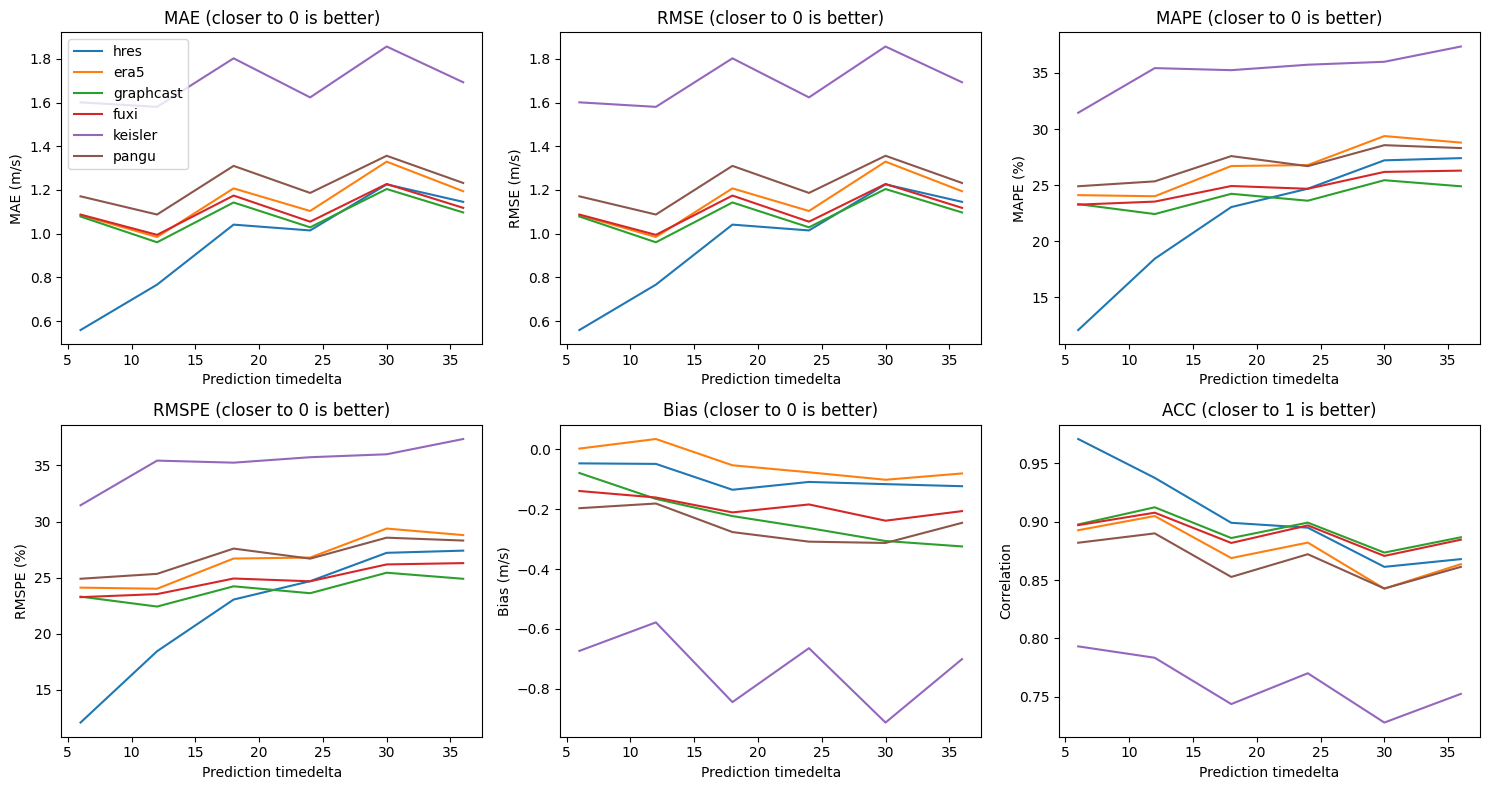

In [28]:
# Plotting

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

x_lin = np.arange(6 , 37, 6)

for i, model in enumerate(models):
    axs[0, 0].plot(x_lin, mae[model['name']][0], label=model['name'])
    axs[0, 0].set_title('MAE (closer to 0 is better)')
    axs[0, 0].set_xlabel('Prediction timedelta')
    axs[0, 0].set_ylabel('MAE (m/s)')

    axs[0, 1].plot(x_lin, rmse[model['name']][0], label=model['name'])
    axs[0, 1].set_title('RMSE (closer to 0 is better)')
    axs[0, 1].set_xlabel('Prediction timedelta')
    axs[0, 1].set_ylabel('RMSE (m/s)')

    axs[0, 2].plot(x_lin, mape[model['name']][0], label=model['name'])
    axs[0, 2].set_title('MAPE (closer to 0 is better)')
    axs[0, 2].set_xlabel('Prediction timedelta')
    axs[0, 2].set_ylabel('MAPE (%)')

    axs[1, 0].plot(x_lin, rmspe[model['name']][0], label=model['name'])
    axs[1, 0].set_title('RMSPE (closer to 0 is better)')
    axs[1, 0].set_xlabel('Prediction timedelta')
    axs[1, 0].set_ylabel('RMSPE (%)')

    axs[1, 1].plot(x_lin, bias[model['name']][0], label=model['name'])
    axs[1, 1].set_title('Bias (closer to 0 is better)')
    axs[1, 1].set_xlabel('Prediction timedelta')
    axs[1, 1].set_ylabel('Bias (m/s)')

    axs[1, 2].plot(x_lin, correlation[model['name']][0], label=model['name'])
    axs[1, 2].set_title('ACC (closer to 1 is better)')
    axs[1, 2].set_xlabel('Prediction timedelta')
    axs[1, 2].set_ylabel('Correlation')


axs[0, 0].legend()
plt.tight_layout()
plt.show()